# Greg

# James

In [1]:
#Imports
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import scipy.stats as stats

Data Bases
rt.movie_info.tsv.gz
bom.movie_gross.csv.gz

In [2]:
!ls zippedData

bom.movie_gross.csv.gz
im.db
im.db.zip
rt.movie_info.tsv.gz
rt.reviews.tsv.gz
tmdb.movies.csv.gz
tn.movie_budgets.csv.gz


In [3]:
#Read the data frame
tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
#Clean columns into floats into floats
tn_movie_budgets["production_budget"] = tn_movie_budgets["production_budget"].map(lambda x : float(x.replace("$","").replace(",","")))
tn_movie_budgets["domestic_gross"] = tn_movie_budgets["domestic_gross"].map(lambda x : float(x.replace("$","").replace(",","")))
tn_movie_budgets["worldwide_gross"] = tn_movie_budgets["worldwide_gross"].map(lambda x : float(x.replace("$","").replace(",","")))
#Creates a date time from release date
tn_movie_budgets["release_date"]=pd.to_datetime(tn_movie_budgets["release_date"])
#Creates a new title column
tn_movie_budgets["title"]= tn_movie_budgets["movie"].map(lambda x :''.join(filter(str.isalnum, x)).lower())
#tn_movie_budgets['return'] = (tn_movie_budgets['worldwide_gross'] - tn_movie_budgets['production_budget']) / tn_movie_budgets['production_budget']

tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,title
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,avatar
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,piratesofthecaribbeanonstrangertides
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,darkphoenix
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,avengersageofultron
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,starwarsepviiithelastjedi
...,...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000.0,0.0,0.000000e+00,red11
5778,79,1999-04-02,Following,6000.0,48482.0,2.404950e+05,following
5779,80,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03,returntothelandofwonders
5780,81,2015-09-29,A Plague So Pleasant,1400.0,0.0,0.000000e+00,aplaguesopleasant


In [4]:

tn_movie_budgets.describe()

,id,production_budget,domestic_gross,worldwide_gross
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09


In [5]:
#gets basic stats 
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tmdb_movies.describe()


,Unnamed: 0,id,popularity,vote_average,vote_count
count,26517.00000,26517.000000,26517.000000,26517.000000,26517.000000
mean,13258.00000,295050.153260,3.130912,5.991281,194.224837
std,7654.94288,153661.615648,4.355229,1.852946,960.961095
min,0.00000,27.000000,0.600000,0.000000,1.000000
25%,6629.00000,157851.000000,0.600000,5.000000,2.000000
50%,13258.00000,309581.000000,1.374000,6.000000,5.000000
75%,19887.00000,419542.000000,3.694000,7.000000,28.000000
max,26516.00000,608444.000000,80.773000,10.000000,22186.000000


In [6]:
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', delimiter = "\t", encoding = "unicode_escape")
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [7]:
rt_movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', delimiter = "\t")
rt_movie_info

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [8]:
movie_gross_db = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_gross_db.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [9]:
conn = sqlite3.connect("zippedData/im.db")

pd.read_sql("""
SELECT name FROM sqlite_master  
  WHERE type='table'
""", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [10]:
q = """
SELECT * FROM movie_basics
WHERE original_title LIKE '%frozen%'
;
"""

pd.read_sql(q, conn)

#movie basics has 150k rows, movie basics has 73k

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10047356,Eises Kälte - Frozen in Time,Eises Kälte - Frozen in Time,2018,92.0,Mystery
1,tt10059478,Frozen Faith: Cryonics and the Quest to Cheat ...,Frozen Faith: Cryonics and the Quest to Cheat ...,2016,NaN,Documentary
2,tt10178906,The Frozen Maze,The Frozen Maze,2018,95.0,"Mystery,Thriller"
3,tt10230504,Extraordinary People: Frozen From Dusk Till Dawn,Extraordinary People: Frozen From Dusk Till Dawn,2018,NaN,Documentary
4,tt10349550,Rapunzel: A Princess Frozen in Time,Rapunzel: A Princess Frozen in Time,2019,90.0,Fantasy
5,tt1323045,Frozen,Frozen,2010,93.0,"Adventure,Drama,Sport"
6,tt1719666,The 2010 Frozen Four Official Championship Film,The 2010 Frozen Four Official Championship Film,2010,69.0,Documentary
7,tt2005374,The Frozen Ground,The Frozen Ground,2013,105.0,"Crime,Drama,Mystery"
8,tt2197378,Frozen Time,Frozen Time,2011,109.0,Drama
9,tt2294629,Frozen,Frozen,2013,102.0,"Adventure,Animation,Comedy"


<AxesSubplot:xlabel='production_budget', ylabel='domestic_gross'>

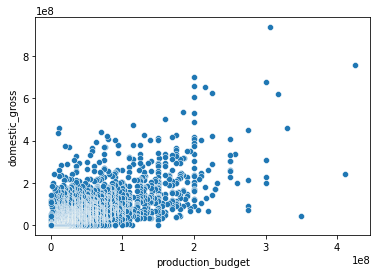

In [11]:
sns.scatterplot(x = tn_movie_budgets["production_budget"], y = tn_movie_budgets["domestic_gross"])


In [12]:
tn_movie_budgets.corr()

,id,production_budget,domestic_gross,worldwide_gross
id,1.000000,-0.035278,0.008255,-0.009422
production_budget,-0.035278,1.000000,0.685682,0.748306
domestic_gross,0.008255,0.685682,1.000000,0.938853
worldwide_gross,-0.009422,0.748306,0.938853,1.000000


Genre Testing

In [35]:
#Create query 
q = """
SELECT * 
FROM movie_basics
"""
#create a DF from the IMBD sql table
imdb_movie_ratings = pd.read_sql(q, conn)
#remove na's from the original title due to low numbers
imdb_movie_ratings.dropna(subset=['original_title'], inplace = True)
imdb_movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146123 non-null  object 
 1   primary_title    146123 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146123 non-null  int64  
 4   runtime_minutes  114401 non-null  float64
 5   genres           140734 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.8+ MB


In [14]:
#create a column for movie names to merge with other DFs   tn_movie_budgets
imdb_movie_ratings['title'] = imdb_movie_ratings['original_title'].map(lambda x :''.join(filter(str.isalnum, x)).lower())

#sets the index on the title field for the merge
tn_movie_budgets.set_index('title', inplace=True)
imdb_movie_ratings.set_index('title', inplace=True)
imdb_movie_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
title,,,,,,
sunghursh,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
ashadkaekdin,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
theothersideofthewind,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
sabsebadasukh,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
latelenovelaerrante,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [15]:
#join new imdb with the numbers table
#tn_movie_budgets.set_index('title', inplace=True)

#combine imdb and the numbers tables
rating_and_budgets = tn_movie_budgets.join(imdb_movie_ratings, how = 'inner')
rating_and_budgets.reset_index(inplace=True)
rating_and_budgets = rating_and_budgets.drop_duplicates(subset='title', keep="first")
rating_and_budgets

,title,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,10cloverfieldlane,54,2016-03-11,10 Cloverfield Lane,5000000.0,72082999.0,1.082864e+08,tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery"
1,10daysinamadhouse,48,2015-11-11,10 Days in a Madhouse,12000000.0,14616.0,1.461600e+04,tt3453052,10 Days in a Madhouse,10 Days in a Madhouse,2015,111.0,Drama
2,127hours,6,2010-11-05,127 Hours,18000000.0,18335230.0,6.021717e+07,tt1542344,127 Hours,127 Hours,2010,94.0,"Adventure,Biography,Drama"
3,12rounds,37,2009-03-27,12 Rounds,20000000.0,12234694.0,1.730665e+07,tt3517850,12 Rounds,12 Rounds,2017,NaN,"Action,Drama,Romance"
4,12strong,64,2018-01-19,12 Strong,35000000.0,45819713.0,7.111838e+07,tt1413492,12 Strong,12 Strong,2018,130.0,"Action,Drama,History"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3763,zookeeper,71,2011-07-08,Zookeeper,80000000.0,80360866.0,1.708055e+08,tt1222817,Zookeeper,Zookeeper,2011,102.0,"Comedy,Family,Romance"
3764,zoolander2,64,2016-02-12,Zoolander 2,50000000.0,28848693.0,5.534869e+07,tt1608290,Zoolander 2,Zoolander 2,2016,101.0,Comedy
3765,zoom,26,2006-08-11,Zoom,35000000.0,11989328.0,1.250619e+07,tt3763866,Zoom,Zoom,2015,96.0,"Animation,Comedy,Drama"
3769,zootopia,57,2016-03-04,Zootopia,150000000.0,341268248.0,1.019430e+09,tt2948356,Zootopia,Zootopia,2016,108.0,"Adventure,Animation,Comedy"


In [16]:
rating_and_budgets['genres'] =  rating_and_budgets['genres'].str.split(',')
rating_and_budgets

,title,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,10cloverfieldlane,54,2016-03-11,10 Cloverfield Lane,5000000.0,72082999.0,1.082864e+08,tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,"[Drama, Horror, Mystery]"
1,10daysinamadhouse,48,2015-11-11,10 Days in a Madhouse,12000000.0,14616.0,1.461600e+04,tt3453052,10 Days in a Madhouse,10 Days in a Madhouse,2015,111.0,[Drama]
2,127hours,6,2010-11-05,127 Hours,18000000.0,18335230.0,6.021717e+07,tt1542344,127 Hours,127 Hours,2010,94.0,"[Adventure, Biography, Drama]"
3,12rounds,37,2009-03-27,12 Rounds,20000000.0,12234694.0,1.730665e+07,tt3517850,12 Rounds,12 Rounds,2017,NaN,"[Action, Drama, Romance]"
4,12strong,64,2018-01-19,12 Strong,35000000.0,45819713.0,7.111838e+07,tt1413492,12 Strong,12 Strong,2018,130.0,"[Action, Drama, History]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3763,zookeeper,71,2011-07-08,Zookeeper,80000000.0,80360866.0,1.708055e+08,tt1222817,Zookeeper,Zookeeper,2011,102.0,"[Comedy, Family, Romance]"
3764,zoolander2,64,2016-02-12,Zoolander 2,50000000.0,28848693.0,5.534869e+07,tt1608290,Zoolander 2,Zoolander 2,2016,101.0,[Comedy]
3765,zoom,26,2006-08-11,Zoom,35000000.0,11989328.0,1.250619e+07,tt3763866,Zoom,Zoom,2015,96.0,"[Animation, Comedy, Drama]"
3769,zootopia,57,2016-03-04,Zootopia,150000000.0,341268248.0,1.019430e+09,tt2948356,Zootopia,Zootopia,2016,108.0,"[Adventure, Animation, Comedy]"


In [18]:
#create dummy collumns to get counts and easy splits
rating_and_budgets=  rating_and_budgets.drop('genres',1).join(rating_and_budgets.genres.str.join('|').str.get_dummies())


In [36]:
#Gets the counts or all of the genre categories
counts = rating_and_budgets.iloc[:,14:42].sum()
#Highest counts - Drama, comedy
print(counts)

Animation       131
Biography       189
Comedy          680
Crime           310
Documentary     196
Drama          1144
Family          139
Fantasy         156
History          69
Horror          285
Music            70
Musical          20
Mystery         169
News              1
Romance         276
Sci-Fi          176
Sport            48
Thriller        392
War              37
Western          20
dtype: int64


In [37]:
#for loops for gathering the 
#for genre in counts.index:
#    worldwide_gross_median.append(rating_and_budgets[rating_and_budgets[genre] == 1]['worldwide_gross'].median())

#goes through each category and gets the statistic from it. Then puts it in a dict with the counts
#median
worldwide_gross_median= [rating_and_budgets[rating_and_budgets[i] == 1]['worldwide_gross'].median() for i in counts.index]    
median_worldwide_gross = dict(zip(counts.index, worldwide_gross_median))

#mode
worldwide_gross_means = [rating_and_budgets[rating_and_budgets[i] == 1]['worldwide_gross'].mean() for i in counts.index]
mean_worldwide_gross = dict(zip(counts.index, worldwide_gross_means))

#count
worldwide_gross_counts = [rating_and_budgets[rating_and_budgets[i] == 1]['worldwide_gross'].count() for i in counts.index]
worldwide_gross_counts = dict(zip(counts.index, worldwide_gross_counts))

#max
worldwide_gross_max = [rating_and_budgets[rating_and_budgets[i] == 1]['worldwide_gross'].max() for i in counts.index]
worldwide_gross_max = dict(zip(counts.index, worldwide_gross_max))

#min
worldwide_gross_min = [rating_and_budgets[rating_and_budgets[i] == 1]['worldwide_gross'].min() for i in counts.index]
worldwide_gross_min = dict(zip(counts.index, worldwide_gross_min))

In [38]:
#sorts the values for data exploration
rating_and_budgets[rating_and_budgets['Music']==1].sort_values('worldwide_gross',ascending=False)

,title,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id,primary_title,original_title,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
403,bohemianrhapsody,84,2018-11-02,Bohemian Rhapsody,55000000.0,216303339.0,894985342.0,tt1727824,Bohemian Rhapsody,Bohemian Rhapsody,...,1,0,0,0,0,0,0,0,0,0
248,astarisborn,5,2018-10-05,A Star is Born,36000000.0,215288866.0,433449571.0,tt1517451,A Star Is Born,A Star Is Born,...,1,0,0,0,1,0,0,0,0,0
1583,lalaland,92,2016-12-09,La La Land,20000000.0,151101803.0,426351163.0,tt3783958,La La Land,La La Land,...,1,0,0,0,0,0,0,0,0,0
2101,pitchperfect2,14,2015-05-15,Pitch Perfect 2,29000000.0,184296230.0,287625468.0,tt2848292,Pitch Perfect 2,Pitch Perfect 2,...,1,0,0,0,0,0,0,0,0,0
2102,pitchperfect3,58,2017-12-22,Pitch Perfect 3,45000000.0,104897530.0,185736412.0,tt4765284,Pitch Perfect 3,Pitch Perfect 3,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,alongtheroadside,91,2015-03-24,Along the Roadside,250000.0,0.0,3234.0,tt2290113,Along the Roadside,Along the Roadside,...,1,0,0,0,1,0,0,0,0,0
162,americanhero,3,2015-12-11,American Hero,1000000.0,0.0,26.0,tt2414176,American Hero,American Hero,...,1,0,0,0,0,0,0,0,0,0
3220,theresaisamother,40,2015-09-29,Theresa Is a Mother,200000.0,0.0,0.0,tt1989646,Theresa Is a Mother,Theresa Is a Mother,...,1,0,0,0,0,0,0,0,0,0
2548,steelspirit,58,2003-12-01,Steel Spirit,20000.0,0.0,0.0,tt4227178,Steel //Spirit,Steel //Spirit,...,1,0,0,0,0,0,0,0,0,0


In [23]:
#creates dataframe to highlight the stats
movie_stats = pd.DataFrame(zip(median_worldwide_gross.values(), mean_worldwide_gross.values(), worldwide_gross_counts.values(), worldwide_gross_max.values(),worldwide_gross_min.values()),median_worldwide_gross.keys(),['Medians','Means','Counts','Max','Min'])

In [39]:
#sorts the DF by median
movie_stats.sort_values('Medians', ascending=False)

,Medians,Means,Counts,Max,Min
Animation,197578586.0,3.006570e+08,131,1.242521e+09,0.0
Fantasy,84720721.5,2.078764e+08,156,1.259200e+09,0.0
Sci-Fi,79476525.5,2.553969e+08,176,2.048134e+09,0.0
News,57293371.0,5.729337e+07,1,5.729337e+07,57293371.0
Comedy,46055025.0,1.122968e+08,680,1.160336e+09,0.0
Family,42174545.0,1.401701e+08,139,1.259200e+09,0.0
Mystery,34246770.0,7.642743e+07,169,5.864643e+08,0.0
Musical,30128794.5,1.309215e+08,20,1.259200e+09,0.0
Crime,27552360.5,6.265413e+07,310,1.234846e+09,0.0
Thriller,25696249.5,8.100579e+07,392,1.234846e+09,0.0


C:\Users\jniegocki\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jniegocki\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='worldwide_gross', ylabel='Density'>

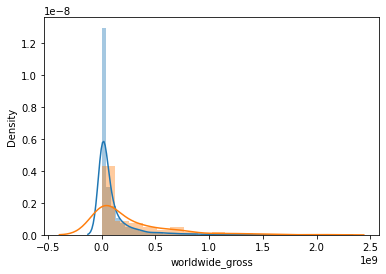

In [40]:
#plot the distribution of overall and the category
sns.distplot(rating_and_budgets['worldwide_gross'])
sns.distplot(rating_and_budgets[rating_and_budgets['Sci-Fi']==1]['worldwide_gross'])

In [42]:
#Creates two DFs, one with Sci-Fi and one without
animated_movies = rating_and_budgets[rating_and_budgets['Sci-Fi'] == 1]
not_animated_movies = rating_and_budgets[rating_and_budgets['Sci-Fi'] == 0]

In [43]:
#Runs a ttest
stats.ttest_ind(animated_movies['worldwide_gross'], not_animated_movies['worldwide_gross'])

Ttest_indResult(statistic=10.570233558029575, pvalue=1.48717395752926e-25)

In [28]:
#Does the above tests for every genre
ttest_res = []
for genre in counts.index:
    genre_movie = rating_and_budgets[rating_and_budgets[genre] == 1]
    not_genre_movies = rating_and_budgets[rating_and_budgets[genre] == 0]
    ttest_res.append(stats.ttest_ind(genre_movie['worldwide_gross'], not_genre_movies['worldwide_gross']))
    
ttest_res

C:\Users\jniegocki\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\jniegocki\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\jniegocki\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


[Ttest_indResult(statistic=11.819691277138588, pvalue=2.2692702400680073e-31),
 Ttest_indResult(statistic=-2.7966397138567887, pvalue=0.005205041694229788),
 Ttest_indResult(statistic=1.047405756099582, pvalue=0.29501843255875276),
 Ttest_indResult(statistic=-4.057785417529457, pvalue=5.1131046465999955e-05),
 Ttest_indResult(statistic=-4.2692549623054825, pvalue=2.0378770368998445e-05),
 Ttest_indResult(statistic=-10.45618829039637, pvalue=4.725721936090204e-25),
 Ttest_indResult(statistic=2.1078758810063034, pvalue=0.0351456427411942),
 Ttest_indResult(statistic=6.674638667694225, pvalue=3.0707557723409656e-11),
 Ttest_indResult(statistic=-2.165103541533435, pvalue=0.030478460461883773),
 Ttest_indResult(statistic=-4.632481554676081, pvalue=3.8070833294726926e-06),
 Ttest_indResult(statistic=-1.8023058719111054, pvalue=0.07162329352077343),
 Ttest_indResult(statistic=0.5708557069525074, pvalue=0.5681511484345387),
 Ttest_indResult(statistic=-1.9623000829139412, pvalue=0.0498434741088

In [29]:
#Creates a DF for all the t-statistics and pvals
tscores = pd.DataFrame(dict(zip(counts.index, ttest_res)), ["Statistic", "Pvalue"]).T

In [44]:
#sorts the df by statistic
tscores.sort_values("Statistic")

,Statistic,Pvalue
Drama,-10.456188,4.725722e-25
Horror,-4.632482,3.807083e-06
Documentary,-4.269255,2.037877e-05
Romance,-4.233917,2.383419e-05
Crime,-4.057785,5.113105e-05
Biography,-2.796640,5.205042e-03
Thriller,-2.656510,7.947929e-03
History,-2.165104,3.047846e-02
Mystery,-1.962300,4.984347e-02
Music,-1.802306,7.162329e-02


In [34]:
#Plot average worldwide gross
#Plot production budget
#Graph top values

len(counts.index)

20

C:\Users\jniegocki\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

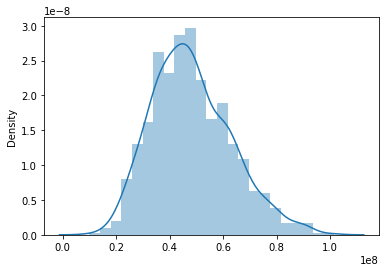

# Han

# Rachel

# Himansri